# TD6: Prévisions diréctionnelles

Nous avons choisis comme Fichier de données plusieurs titres:

-  $\textbf{AIG}$ : c' est le nom commercial du réseau mondial d’assurance dommages et responsabilité de American International Group, Inc. AIG est l’un des leaders mondiaux de l’assurance et des services financiers. 

- $\textbf{Amazon}$ : une entreprise de commerce en ligne

- $\textbf{Colgate-Palmolive}$ : une entreprise américaine spécialisée dans la fabrication et la commercialisation de produits d'entretien et de produits d'hygiène tels que les détergents, les savons, les dentifrices et les brosses à dents.

- $\textbf{Exxon Mobil Corp.}$ :  est une société pétrolière et gazière américaine.



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Activation, Reshape,Flatten, Dropout, Lambda, RepeatVector
from tensorflow.keras.layers import Add,Multiply
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling1D, Conv1D
from tensorflow.keras.layers import ReLU,LeakyReLU
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
# Import de nos drive pour les fichiers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


On charge les cotations des 4 titres mentionnés ci-dessus : 

In [ ]:
AIG = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD6/AIG_2021-02-22.csv.gz',compression='gzip',index_col=0)
Amazon = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD6/AMZN_2021-02-22.csv.gz',compression='gzip',index_col=0)
ColgPalm = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD6/CL_2021-02-22.csv.gz',compression='gzip',index_col=0)
Exxon = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD6/XOM_2021-02-22.csv.gz',compression='gzip',index_col=0)

In [ ]:
# From Deep Learning for Time Series Forecasting (c) Jason Brownlee

#split a univariate sequence into samples
def split_sequence_univariate(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        #seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, -1]
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# Transforms a 2d-X and y to 3d X and y


# split a multivariate sequence into samples
def split_sequences_multivariate(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
AIG.head()

,Open,High,Low,Close,Volume,Adjusted,ticker
index,,,,,,,
2006-02-23,1351.599976,1353.400024,1330.800049,1344.000000,314525.0,908.666382,AIG
2006-02-24,1347.400024,1349.599976,1337.199951,1339.400024,210515.0,905.556519,AIG
2006-02-27,1339.400024,1347.599976,1332.400024,1342.199951,261885.0,907.449463,AIG
2006-02-28,1337.199951,1341.000000,1325.199951,1327.199951,355115.0,897.308289,AIG
2006-03-01,1325.800049,1337.000000,1319.199951,1324.400024,265980.0,897.443909,AIG


In [ ]:
AIG["log_ret"] = np.log(AIG.Adjusted.shift(1))-np.log(AIG.Adjusted)
AIG = AIG.dropna()

Nous avons differentes possiblitées pour travailler sur les rendements , nous pouvons etudier : 

- Le signe des rendements en essayant de predir le signe du rendement suivant , c 'est  dire un bit de données ce qui permet de s'affranchir du bruit existant dans les autres bits. En effet les series sont trops bruitées.

- On peut aussi utiliser le zscore ou les quantiles 

In [ ]:
AIG["ret_sign"] = np.sign(AIG.log_ret)

Nous allons utiliser un reseaux de neurones reccurents afin de prédire le signe des rendements: 

- On fait l'hypothese que les rendements peuvent avoir 3 signes : {-1,0,1}.On va donc classifeir les rendements futur dans ces categories.

- Les series de rendements sont adaptées sont adaptés a l'utilisation de réseaux réccurents. Nous faisons le choix d'un réseaux LSTM qui permet d'éviter le vanishing gradient.

In [ ]:
AIG

,Open,High,Low,Close,Volume,Adjusted,ticker,log_ret,ret_sign
index,,,,,,,,,
2006-02-24,1347.400024,1349.599976,1337.199951,1339.400024,210515.0,905.556519,AIG,0.003428,1.0
2006-02-27,1339.400024,1347.599976,1332.400024,1342.199951,261885.0,907.449463,AIG,-0.002088,-1.0
2006-02-28,1337.199951,1341.000000,1325.199951,1327.199951,355115.0,897.308289,AIG,0.011238,1.0
2006-03-01,1325.800049,1337.000000,1319.199951,1324.400024,265980.0,897.443909,AIG,-0.000151,-1.0
2006-03-02,1318.000000,1322.599976,1310.400024,1316.000000,328885.0,891.751526,AIG,0.006363,1.0
...,...,...,...,...,...,...,...,...,...
2021-02-12,41.459999,42.189999,41.189999,41.400002,4153900.0,41.400002,AIG,0.004819,1.0
2021-02-16,41.740002,42.630001,41.509998,42.150002,4934900.0,42.150002,AIG,-0.017954,-1.0
2021-02-17,41.279999,43.360001,41.169998,43.270000,4872000.0,43.270000,AIG,-0.026225,-1.0


#### Architecture LSTM : 

Dans cette partie on definit un Model Compilé LSTM ainsi que les fonctions d'entrainement et prédiction.

Nous allons détailler les notations : 

- T_in : taille de la fenêtre d'entrainement.
- Batch Size : taille des batchs d'entrainement.
- dT : taille du batch prédiction.
- nb_epochs : le nombre de fois ou on parcourt entièrement le DataSet.
- Nb_neurons : Nombre de neurones par couche.

Nous utlise un dropout pendant la phase d'entrainement pour éviter l'overfitting.

La fonction $\textit{Generic_LSTM}$ renvoie un LSTM multi-couches compilé.

In [ ]:
def Generic_LSTM (Nb_neurons,batch_size,sizesamples,summary = False):

  
  model = Sequential()
  model.add(LSTM(units = Nb_neurons , batch_input_shape=(batch_size,sizesamples[1],sizesamples[2]),return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = Nb_neurons ,return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units = Nb_neurons ,return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units = Nb_neurons, stateful=True))
  model.add(Dropout(0.2))
  # Adding the output layer
  model.add(Dense(units = 3,activation='softmax'))
  Opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) ## Valeurs par defaults ;
  model.compile(loss='categorical_crossentropy', optimizer= Opt, metrics=['accuracy'])
  if summary == True :
    model.summary()

  return model

La fonction $\textit{Global_LSTM}$ prend en entrée un LSTM compilé ainsi que les X_train et y_train.Le reseaux est alors entrainée sur chaque fenetres.Nous recupérons en sortie l'historique des prédictions.

In [ ]:
def Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X,Y,type = 'classification',shfle = False):

      LSTM_Training =  Generic_LSTM(neurons_lstm, batch_size, X.shape,summary = False) 
      if type ==   'classification' : 
        LSTM_History = np.array([0]*Y.shape[1],ndmin=2)
      else: 
        LSTM_History = np.array([])

      for t in tqdm(np.arange(T_in,X.shape[0]-T_in,dT)):

          LSTM_Training.fit(X[t-T_in:t],Y[t-T_in:t], batch_size = batch_size, epochs = nb_epochs , shuffle = shfle,verbose=0)
          LSTM_Forecast = Generic_LSTM(neurons_lstm, dT, X.shape) ; LSTM_Forecast.set_weights(LSTM_Training.get_weights())
          forecast = LSTM_Forecast.predict(X[t:t+dT],batch_size=dT) ; LSTM_History = np.concatenate((LSTM_History, forecast), axis=0) ## Rajoute les nouvelles predictions

      return LSTM_History


## 1: Rendements seuls



In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

On construit le $\textit{X_train}$ et le $\textit{Y_train}$.



In [ ]:
X_full = AIG[["log_ret"]].values                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample, y_sample  = split_sequence_univariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(3673, 100, 1)
(3673, 1)


In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample[:,0])
encoded_Y = encoder.transform(y_sample[:,0])
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

In [ ]:
LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 

In [ ]:
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsI = pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsI

,labels,pred
0,0,2
1,0,2
2,0,2
3,2,2
4,2,2
...,...,...
1195,0,0
1196,2,0
1197,0,0
1198,2,0


In [ ]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsI.labels,resultsI.pred)
AccI = (matrix_conf[0,0] + matrix_conf[1,1])/resultsI.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsI.shape[0]}")

Accuracy : 0.21916666666666668


> Il apparait que la classification est de trés mauvaise qualitée.L'utilisation des signes de logret de la serie pour prédire les signes des logrets rendements futurs n'est pas un bon prédicteur.

On note aussi que les résultats ne sont pas stables.Les resultats changent significativements quand on relance l'entrainement et la prédiction.


## 2 : Rendements et OHLC

- Nous gardons les rendements  brutes mais cette fois ci nous rajoutons de nouveaux prédicteurs.

- Nous avons ajouté trois nouveau prédicteurs :
  - $h = \log(\frac{H}{O})$
  - $l = \log(\frac{L}{O})$
  - $c = \log(\frac{C}{O})$



In [ ]:
AIG["h"] = np.log(AIG.High/AIG.Open) ; AIG["l"] = np.log(AIG.Low/AIG.Open) ; AIG["c"] = np.log(AIG.Close/AIG.Open) ; 
AIG

,Open,High,Low,Close,Volume,Adjusted,ticker,log_ret,ret_sign,h,l,c
index,,,,,,,,,,,,
2006-02-24,1347.400024,1349.599976,1337.199951,1339.400024,210515.0,905.556519,AIG,0.003428,1.0,0.001631,-0.007599,-0.005955
2006-02-27,1339.400024,1347.599976,1332.400024,1342.199951,261885.0,907.449463,AIG,-0.002088,-1.0,0.006103,-0.005240,0.002088
2006-02-28,1337.199951,1341.000000,1325.199951,1327.199951,355115.0,897.308289,AIG,0.011238,1.0,0.002838,-0.009014,-0.007506
2006-03-01,1325.800049,1337.000000,1319.199951,1324.400024,265980.0,897.443909,AIG,-0.000151,-1.0,0.008412,-0.004991,-0.001057
2006-03-02,1318.000000,1322.599976,1310.400024,1316.000000,328885.0,891.751526,AIG,0.006363,1.0,0.003484,-0.005783,-0.001519
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-12,41.459999,42.189999,41.189999,41.400002,4153900.0,41.400002,AIG,0.004819,1.0,0.017454,-0.006534,-0.001448
2021-02-16,41.740002,42.630001,41.509998,42.150002,4934900.0,42.150002,AIG,-0.017954,-1.0,0.021098,-0.005526,0.009775
2021-02-17,41.279999,43.360001,41.169998,43.270000,4872000.0,43.270000,AIG,-0.026225,-1.0,0.049159,-0.002668,0.047081


In [ ]:
X_full = AIG[["h","l","c","log_ret"]].values                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(3673, 100, 4)
(3673,)


In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample)
encoded_Y = encoder.transform(y_sample)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

In [ ]:
LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 

In [ ]:
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsII = pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsII

,labels,pred
0,0,2
1,0,2
2,0,2
3,2,2
4,2,2
...,...,...
1195,0,0
1196,2,0
1197,0,0
1198,2,0


In [ ]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsII.labels,resultsII.pred)
AccII = (matrix_conf[0,0] + matrix_conf[1,1])/resultsII.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsII.shape[0]}")

Accuracy : 0.21916666666666668


> Il apparait que la classification est de trés mauvaise qualitée aussi dans ce cas.L'utilisation des signes de logret  et des ratios introduits pour prédire les signes des logrets rendements futurs ne sont pas de bons prédicteurs.

On observe le même phénoméne que précédement avec des résultats trés instables.


## 3 : Rendements, OHLC et volume

- Nous  ajoutons maintenant log-volume.

In [ ]:
AIG["log_volume"] = np.log(AIG.Volume)

In [ ]:
X_full = AIG[["h","l","c","log_volume","log_ret"]].values                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(3673, 100, 5)
(3673,)


In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample)
encoded_Y = encoder.transform(y_sample)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

In [ ]:
LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsIII = pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsIII

,labels,pred
0,0,2
1,0,2
2,0,2
3,2,2
4,2,2
...,...,...
1195,0,2
1196,2,2
1197,0,0
1198,2,2


In [ ]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsIII.labels,resultsIII.pred)
AccIII = (matrix_conf[0,0] + matrix_conf[1,1])/resultsIII.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsIII.shape[0]}")

Accuracy : 0.20333333333333334


> Il apparait que la classification est de trés mauvaise qualitée aussi dans ce cas.L'utilisation des signes de logret  et des ratios introduits pour prédire les signes des logrets rendements futurs ne sont pas de bons prédicteurs.

On observe le même phénoméne que précédement avec des résultats trés instables.

## 4 : Comparaison des Performances

> Aucun des prédicteurs utilisés ne semble satisfaisant.En effet nous obtenons des accuracy trés faibles à chaque fois.Neamoins le fait d'avoir utilisé cette methode sur un seul titre de donne aucune indication sur les perfromances qu'elle peut avoir sur d'autres titres.

Dans la questions suivante , nous allons chercher à détérminer si la pérformance est aussi faible pour d'autres titres que AIG.

Nous allons pour cela appliquer le LSTM poour les titres Exxon, Colgate Palmolive et Amazon. 

#### Exxon :

In [ ]:
Exxon.head()

,Open,High,Low,Close,Volume,Adjusted,ticker
index,,,,,,,
2006-02-23,60.009998,60.540001,59.630001,59.830002,17732100,36.661789,XOM
2006-02-24,60.340000,60.730000,60.180000,60.419998,13178800,37.023319,XOM
2006-02-27,60.200001,60.520000,59.900002,59.919998,12549500,36.716923,XOM
2006-02-28,59.520000,59.750000,59.099998,59.369999,19191800,36.379906,XOM
2006-03-01,59.590000,60.540001,59.529999,60.340000,16335400,36.974297,XOM


In [ ]:
Exxon["log_ret"] = np.log(Exxon.Adjusted.shift(1))-np.log(Exxon.Adjusted) ; Exxon = Exxon.dropna()
Exxon["ret_sign"] = np.sign(Exxon.log_ret)
Exxon["h"] = np.log(Exxon.High/Exxon.Open) ; Exxon["l"] = np.log(Exxon.Low/Exxon.Open) ; Exxon["c"] = np.log(Exxon.Close/Exxon.Open) ; 
Exxon["log_volume"] = np.log(Exxon.Volume)

In [ ]:
X_full = Exxon[["h","l","c","log_volume","log_ret"]].values                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(3671, 100, 5)
(3671,)


In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample)
encoded_Y = encoder.transform(y_sample)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

In [ ]:
LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsIIIExx = pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsIIIExx

,labels,pred
0,2,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1195,2,2
1196,2,2
1197,2,2
1198,1,2


In [ ]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsIIIExx.labels,resultsIIIExx.pred)
AccIIIExx = (matrix_conf[0,0] + matrix_conf[1,1])/resultsIIIExx.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsIIIExx.shape[0]}")

Accuracy : 0.4508333333333333


#### Colgate Palmolive

In [ ]:
ColgPalm.head()

,Open,High,Low,Close,Volume,Adjusted,ticker
index,,,,,,,
2006-02-23,27.174999,27.495001,27.125000,27.325001,2954600,19.273298,CL
2006-02-24,27.400000,27.500000,27.250000,27.309999,3006600,19.262722,CL
2006-02-27,27.184999,27.764999,27.150000,27.715000,3451800,19.548389,CL
2006-02-28,27.650000,27.870001,27.225000,27.240000,3622800,19.213345,CL
2006-03-01,27.340000,27.475000,27.245001,27.385000,2252600,19.315615,CL


In [ ]:
ColgPalm["log_ret"] = np.log(ColgPalm.Adjusted.shift(1))-np.log(ColgPalm.Adjusted) ; ColgPalm = ColgPalm.dropna()
ColgPalm["ret_sign"] = np.sign(ColgPalm.log_ret)
ColgPalm["h"] = np.log(ColgPalm.High/ColgPalm.Open) ; ColgPalm["l"] = np.log(ColgPalm.Low/ColgPalm.Open) ; ColgPalm["c"] = np.log(ColgPalm.Close/ColgPalm.Open) ; 
ColgPalm["log_volume"] = np.log(ColgPalm.Volume)

In [ ]:
X_full = ColgPalm[["h","l","c","log_volume","log_ret"]].values                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(3671, 100, 5)
(3671,)


In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample)
encoded_Y = encoder.transform(y_sample)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

In [ ]:
LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsIIICPam = pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsIIICPam

,labels,pred
0,0,0
1,2,0
2,0,0
3,0,0
4,2,0
...,...,...
1195,0,0
1196,2,0
1197,0,0
1198,2,0


In [ ]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsIIICPam.labels,resultsIIICPam.pred)
AccIIICPam = (matrix_conf[0,0] + matrix_conf[1,1])/resultsIIICPam.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsIIICPam.shape[0]}")

Accuracy : 0.52


#### Amazon : 

In [ ]:
Amazon.head()

,Open,High,Low,Close,Volume,Adjusted,ticker
index,,,,,,,
2006-02-23,38.619999,38.750000,37.869999,37.900002,9287500,37.900002,AMZN
2006-02-24,38.250000,38.410000,37.860001,38.349998,3720000,38.349998,AMZN
2006-02-27,38.400002,38.779999,37.930000,38.009998,4449100,38.009998,AMZN
2006-02-28,37.790001,38.090000,37.049999,37.439999,9150900,37.439999,AMZN
2006-03-01,37.450001,37.689999,36.849998,37.119999,6981500,37.119999,AMZN


In [ ]:
Amazon["log_ret"] = np.log(Amazon.Adjusted.shift(1))-np.log(Amazon.Adjusted) ; Amazon = Amazon.dropna()
Amazon["ret_sign"] = np.sign(Amazon.log_ret)
Amazon["h"] = np.log(Amazon.High/Amazon.Open) ; Amazon["l"] = np.log(Amazon.Low/Amazon.Open) ; Amazon["c"] = np.log(Amazon.Close/Amazon.Open) ; 
Amazon["log_volume"] = np.log(Amazon.Volume)

In [ ]:
X_full = Amazon[["h","l","c","log_volume","log_ret"]].values                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(3671, 100, 5)
(3671,)


In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample)
encoded_Y = encoder.transform(y_sample)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

In [ ]:
LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsIIIAmz = pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsIIIAmz

,labels,pred
0,2,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
1195,0,0
1196,2,0
1197,2,0
1198,2,0


In [ ]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsIIIAmz.labels,resultsIIIAmz.pred)
AccIIIAmz = (matrix_conf[0,0] + matrix_conf[1,1])/resultsIIIAmz.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsIIIAmz.shape[0]}")

Accuracy : 0.3541666666666667


### Comparaison Performances cross séctionelles : 

L'ensemble des features utilisés sont les mêmes pour les quatres titres.

In [ ]:
Bilan = pd.DataFrame(columns=['AIG','Exxon','ColgatePalm','Amazon'])
Bilan = Bilan.append({'AIG' : AccIII , 'Exxon' : AccIIIExx , 'ColgatePalm' : AccIIICPam , 'Amazon' : AccIIIAmz}, ignore_index=True)
Bilan = Bilan.set_index([pd.Index(['Accuracy'])]);
Bilan

,AIG,Exxon,ColgatePalm,Amazon
Accuracy,0.203333,0.450833,0.52,0.354167



Nous obtenons des résultats trés interéssants lorsque nous comparons l'accuracy du LSTM dans la prediction du signe des rendements.

Dans le cas d'un resaux qui classifit au hasard on peut s'attendre à avoir une accuracy qui est trés instables et qui suit une loi uniforme c 'est a dire qu'avec un echantillon de test trés grand il classifit bien une fois sur 3.

On observe pour le tableau comparatif qu'il y a des forte difference sur l'accuracy.

Dans notre cas on obtient des reusltats trés instables pour le titre AIG don l'accuracy varie en moyenne entre 18 et 30% quand on relance l'entrainement et la prediction plusieurs fois . On en deduit que le reseaux n'apprend rien et les poids ne cessent de changer significativements au fur et à mesure des épochs sans jamais converger.En effet avec un nombre d'epoch de 200 nous devrions observer une convergence si le réseau avait reussit à apprendre.

Nous affichons ci dessous les courbes des titres pour essayer d'intuiter en quoi les titres different et si il y a un pattern a identifier qui pourrait nous aider à comprendre les differences entre les accuracy.

In [ ]:
AIG.iloc[500:,:]

,Open,High,Low,Close,Volume,Adjusted,ticker
index,,,,,,,
2008-02-20,934.400024,965.000000,933.799988,958.000000,1026360.0,661.497498,AIG
2008-02-21,969.599976,977.599976,945.599976,951.799988,816390.0,657.216309,AIG
2008-02-22,953.799988,978.200012,938.000000,977.599976,982005.0,675.031067,AIG
2008-02-25,972.799988,1011.400024,962.200012,1007.599976,1245585.0,695.746033,AIG
2008-02-26,1002.200012,1032.400024,1000.000000,1028.400024,1189645.0,710.108582,AIG
...,...,...,...,...,...,...,...
2021-02-12,41.459999,42.189999,41.189999,41.400002,4153900.0,41.400002,AIG
2021-02-16,41.740002,42.630001,41.509998,42.150002,4934900.0,42.150002,AIG
2021-02-17,41.279999,43.360001,41.169998,43.270000,4872000.0,43.270000,AIG


Text(0.5, 1.0, 'log returns Amazon')

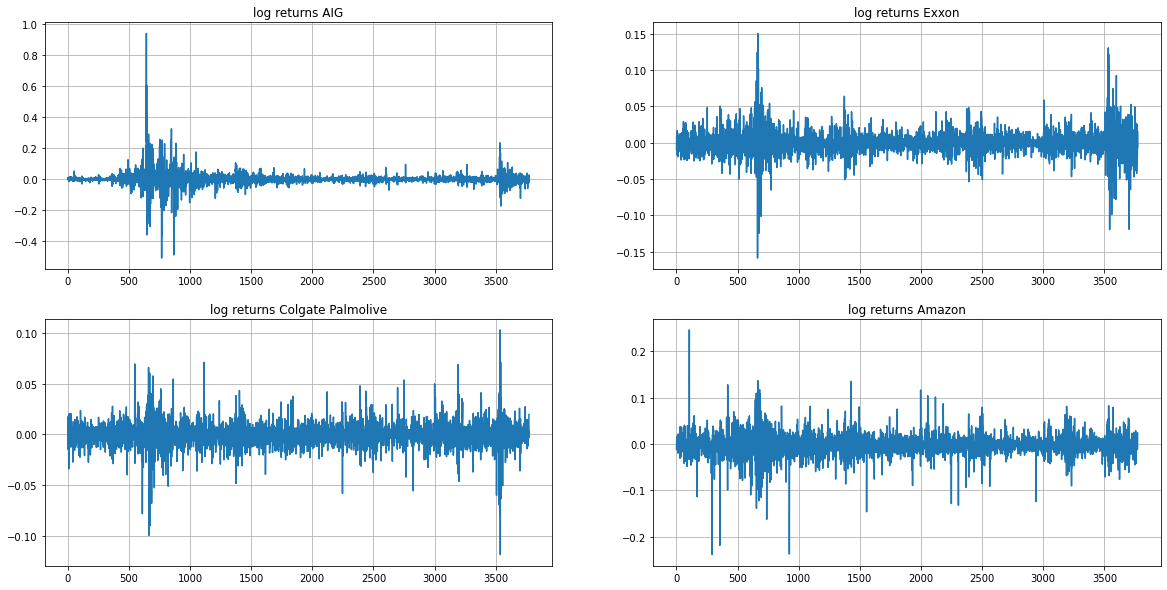

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(AIG.log_ret.values, label= 'AIG') ; ax[0,0].grid() ; ax[0,0].set_title("log returns AIG")
ax[0,1].plot(Exxon.log_ret.values, label= 'Exxon'); ax[0,1].grid() ; ax[0,1].set_title("log returns Exxon")
ax[1,0].plot(ColgPalm.log_ret.values, label= 'ColgPalm'); ax[1,0].grid() ; ax[1,0].set_title("log returns Colgate Palmolive")
ax[1,1].plot(Amazon.log_ret.values, label= 'Amazon'); ax[1,1].grid() ; ax[1,1].set_title("log returns Amazon")


Text(0.5, 1.0, 'Adjusted Close Amazon')

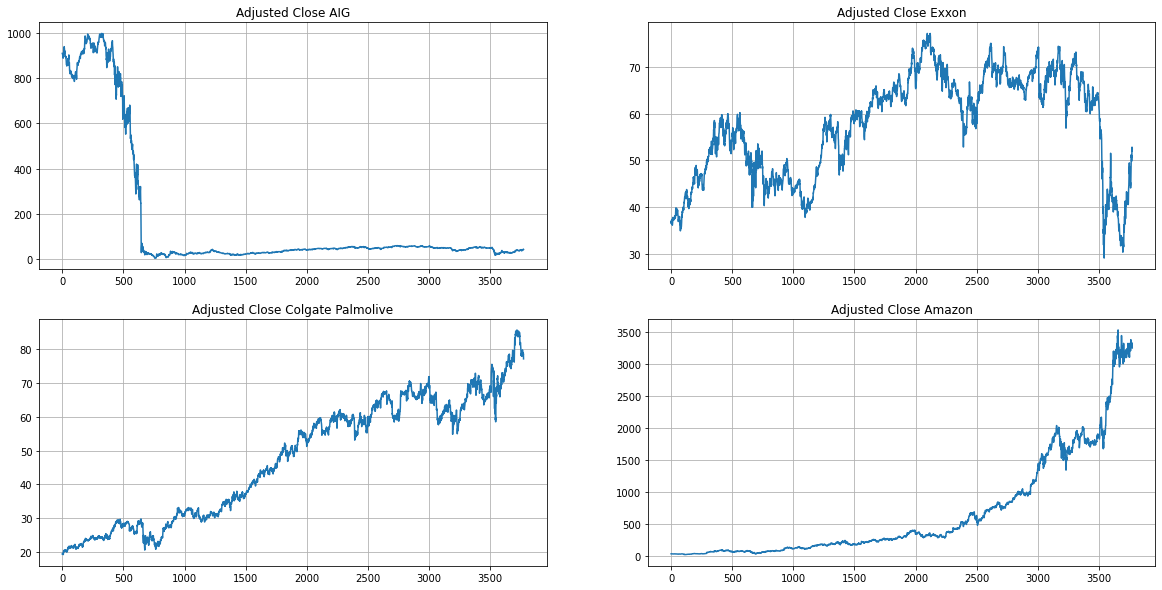

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(AIG.Adjusted.values, label= 'AIG') ; ax[0,0].grid() ; ax[0,0].set_title("Adjusted Close AIG")
ax[0,1].plot(Exxon.Adjusted.values, label= 'Exxon'); ax[0,1].grid() ; ax[0,1].set_title("Adjusted Close Exxon")
ax[1,0].plot(ColgPalm.Adjusted.values, label= 'ColgPalm'); ax[1,0].grid() ; ax[1,0].set_title("Adjusted Close Colgate Palmolive")
ax[1,1].plot(Amazon.Adjusted.values, label= 'Amazon'); ax[1,1].grid() ; ax[1,1].set_title("Adjusted Close Amazon")


> un des premiers constat est la chute du titre en 2008 de AIG qui à été renfloué ( bail out des banques en 2008) .

Text(0.5, 1.0, 'Adjusted Close AIG a partir de 2009')

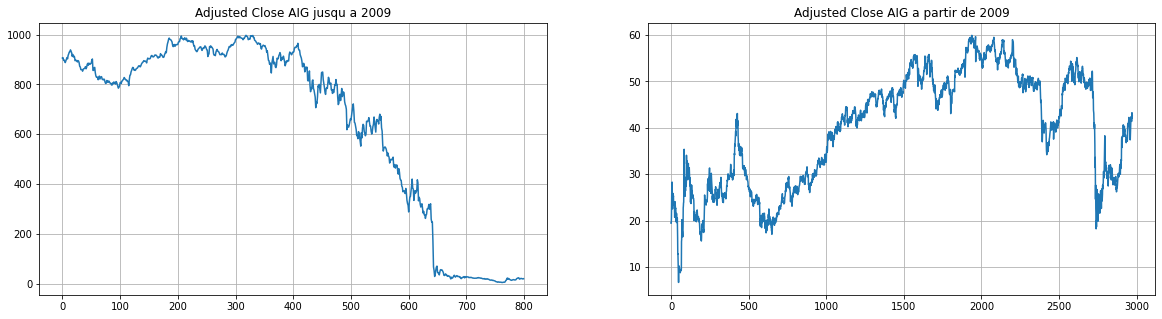

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(AIG.Adjusted.values[:800], label= 'AIG') ; ax[0].grid() ; ax[0].set_title("Adjusted Close AIG jusqu a 2009")
ax[1].plot(AIG.Adjusted.values[800:], label= 'AIG') ; ax[1].grid() ; ax[1].set_title("Adjusted Close AIG a partir de 2009")


> Il serait intéressant de tester si les resultats peuvent être  ameliorés en seperant la series en deux périodes: 

- Une premiére periode bear en 2009 et puis une tendance a la hausse jusqu'au covid19.

On relance le LSTM sur chaque serie : 

#### Periode avant 2009 :

In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*5 ## Le nombre de samples pris pour chaque entrainement. 
dT= 10 # Nombre de points entre deux etapes de calibration

In [ ]:
X_full = AIG[["h","l","c","log_volume","log_ret"]].values[:800]                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(700, 100, 5)
(700,)


In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample)
encoded_Y = encoder.transform(y_sample)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

In [ ]:
LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsAIG_Bef2009= pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsAIG_Bef2009

In [ ]:
from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsAIG_Bef2009.labels,resultsAIG_Bef2009.pred)
AccRegAI_Bef2009 = (matrix_conf[0,0] + matrix_conf[1,1])/resultsAIG_Bef2009.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsAIG_Bef2009.shape[0]}")

Accuracy : 0.31666666666666665


> On obtient une meilleur accuracy que sur la serie entiére mais elle reste trés faible.

#### Période aprés 2009 : 

In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

In [ ]:
X_full = AIG[["h","l","c","log_volume","log_ret"]].values[800:]                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
y_sample = np.sign(y_sample)
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_sample)
encoded_Y = encoder.transform(y_sample)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
one_hot_y_sample = dummy_y 

LSTM_History = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,one_hot_y_sample,type = 'classification',shfle = False)

(2873, 100, 5)
(2873,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [ ]:
y_pred = LSTM_History[1:,:] ## On prend pas la 1 ere ligne car sert juste à l'init ; elle n'a aucun sens
y_pred = np.argmax(y_pred,axis=1) ## On prend la classe pour laquelle la proba est maximale 
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; y_true = encoded_Y[N_I + seq[0]:seq[-1]+N_I+dT]
resultsAIG_Aft2009= pd.DataFrame(data = { 'labels' : y_true , 'pred' : y_pred})
resultsAIG_Aft2009

from sklearn.metrics import confusion_matrix
matrix_conf = confusion_matrix(resultsAIG_Aft2009.labels,resultsAIG_Aft2009.pred)
AccRegAI_Aft2009 = (matrix_conf[0,0] + matrix_conf[1,1])/resultsAIG_Aft2009.shape[0]
print(f"Accuracy : {(matrix_conf[0,0] + matrix_conf[1,1])/resultsAIG_Aft2009.shape[0]}")

Accuracy : 0.515


> l'accuray semble bien meilleur pour cette periode.